# Qcodes example with Alazar ATS 9360

In [1]:
# import all necessary things
%matplotlib nbagg

import qcodes as qc
import qcodes.instrument.parameter as parameter
import qcodes.instrument_drivers.AlazarTech.ATS9360 as ATSdriver
import qcodes.instrument_drivers.AlazarTech.ATS_acquisition_controllers as ats_contr

User schema at C:\Users\Jens\qcodesrc_schema.json not found.User settings won't be validated


In [2]:
# Command to list all alazar boards connected to the system
ATSdriver.AlazarTech_ATS.find_boards()

[{'system_id': 1,
  'board_id': 1,
  'board_kind': 'ATS9360',
  'max_samples': 4294967294,
  'bits_per_sample': 12}]

In [3]:
# Create the ATS9870 instrument on the new server "alazar_server"
ats_inst = ATSdriver.AlazarTech_ATS9360(name='Alazar1')
# Print all information about this Alazar card
ats_inst.get_idn()

{'firmware': None,
 'model': 'ATS9360',
 'max_samples': 4294967294,
 'bits_per_sample': 12,
 'serial': '970396',
 'vendor': 'AlazarTech',
 'CPLD_version': '25.16',
 'driver_version': '6.1.2',
 'SDK_version': '6.1.2',
 'latest_cal_date': '25-01-17',
 'memory_size': '4294967294',
 'asopc_type': '1779729248',
 'pcie_link_speed': '0.5GB/s',
 'pcie_link_width': '8'}

In [4]:
# Instantiate an acquisition controller (In this case we are doing a simple DFT) and 
# provide the name of the name of the alazar card that this controller should control
acquisition_controller = ats_contr.Demodulation_AcquisitionController(name='acquisition_controller', 
                                                                      demodulation_frequency=10e6, 
                                                                      alazar_name='Alazar1')

In [13]:
with ats_inst.syncing():
    ats_inst.clock_source('INTERNAL_CLOCK')
    ats_inst.sample_rate(1_000_000_000)
    ats_inst.clock_edge('CLOCK_EDGE_RISING')
    ats_inst.decimation(1)
    ats_inst.coupling1('DC')
    ats_inst.coupling2('DC')
    ats_inst.channel_range1(.4)
    ats_inst.channel_range2(.4)
    ats_inst.impedance1(50)
    ats_inst.impedance2(50)
    ats_inst.trigger_operation('TRIG_ENGINE_OP_J')
    ats_inst.trigger_engine1('TRIG_ENGINE_J')
    ats_inst.trigger_source1('EXTERNAL')
    ats_inst.trigger_slope1('TRIG_SLOPE_POSITIVE')
    ats_inst.trigger_level1(160)
    ats_inst.trigger_engine2('TRIG_ENGINE_K')
    ats_inst.trigger_source2('DISABLE')
    ats_inst.trigger_slope2('TRIG_SLOPE_POSITIVE')
    ats_inst.trigger_level2(128)
    ats_inst.external_trigger_coupling('DC')
    ats_inst.external_trigger_range('ETR_2V5')
    ats_inst.trigger_delay(0)
    ats_inst.timeout_ticks(0)
    ats_inst.aux_io_mode('AUX_IN_AUXILIARY') # AUX_IN_TRIGGER_ENABLE for seq mode on
    ats_inst.aux_io_param('NONE') # TRIG_SLOPE_POSITIVE for seq mode on

In [14]:
# This command is specific to this acquisition controller. The kwargs provided here are being forwarded to ats_inst.acquire
# This way, it becomes easy to change acquisition specific settings from the ipython notebook
acquisition_controller.update_acquisitionkwargs(#mode='NPT',
                 samples_per_record=1024,
                 records_per_buffer=70,
                 buffers_per_acquisition=1,
                 #channel_selection='AB',
                 #transfer_offset=0,
                 #external_startcapture='ENABLED',
                 #enable_record_headers='DISABLED',
                 #alloc_buffers='DISABLED',
                 #fifo_only_streaming='DISABLED',
                 #interleave_samples='DISABLED',
                 #get_processed_data='DISABLED',
                 allocated_buffers=1,
                 #buffer_timeout=1000
)

In [15]:
# Getting the value of the parameter 'acquisition' of the instrument 'acquisition_controller' performes the entire acquisition 
# protocol. This again depends on the specific implementation of the acquisition controller
acquisition_controller.acquisition()

4.505166821500234

In [16]:
# make a snapshot of the 'ats_inst' instrument
ats_inst.snapshot()

{'functions': {},
 'submodules': {},
 '__class__': 'qcodes.instrument_drivers.AlazarTech.ATS9360.AlazarTech_ATS9360',
 'parameters': {'IDN': {'value': None,
   'ts': None,
   'raw_value': None,
   '__class__': 'qcodes.instrument.parameter.Parameter',
   'full_name': 'Alazar1_IDN',
   'vals': '<Anything>',
   'label': 'IDN',
   'unit': '',
   'instrument': 'qcodes.instrument_drivers.AlazarTech.ATS9360.AlazarTech_ATS9360',
   'instrument_name': 'Alazar1',
   'inter_delay': 0,
   'post_delay': 0,
   'name': 'IDN'},
  'clock_source': {'value': 'INTERNAL_CLOCK',
   'ts': '2018-10-05 13:49:22',
   'raw_value': 1,
   '__class__': 'qcodes.instrument_drivers.AlazarTech.utils.TraceParameter',
   'full_name': 'Alazar1_clock_source',
   'vals': "<Enum: {'INTERNAL_CLOCK', 'EXTERNAL_CLOCK_10MHz_REF', 'FAST_EXTERNAL_CLOCK'}>",
   'label': 'Clock Source',
   'unit': '',
   'instrument': 'qcodes.instrument_drivers.AlazarTech.ATS9360.AlazarTech_ATS9360',
   'instrument_name': 'Alazar1',
   'val_mapping'

Started at 2018-10-05 13:49:24
DataSet:
   location = 'data/2018-10-05/#001_AlazarTest_13-49-24'
   <Type>   | <array_id>                         | <array.name> | <array.shape>
   Setpoint | dummy_set                          | dummy        | (50,)
   Measured | acquisition_controller_acquisition | acquisition  | (50,)
Finished at 2018-10-05 13:49:28


<IPython.core.display.Javascript object>


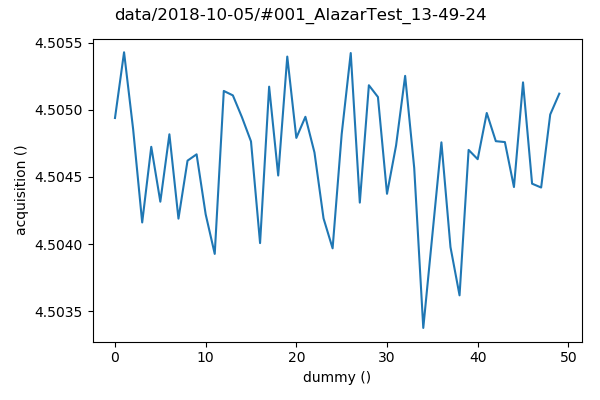

In [17]:
# Finally show that this instrument also works within a loop
dummy = parameter.ManualParameter(name="dummy")
data = qc.Loop(dummy[0:50:1]).each(acquisition_controller.acquisition).run(name='AlazarTest')
qc.MatPlot(data.acquisition_controller_acquisition)